# Lasso Regression Analysis

This is an assignment for week 3 of the 'Regression Modeling in Practice' course by Wesleyan University.

A lasso regression analysis was conducted to identify a subset of variables from a pool of 14 categorical and quantitative independent variables that best predicted a quantitative response variable measuring the trade openness of a country. 

Categorical predictors include binary variables for WTO membership and landlocked-'ness' of a country and a series of 7 binary categorical variables for the region of the world (East Asia & Pacific, Europe & Central Asia, Latin America & Caribbean, Middle East & North Africa, North America, South Asia, Sub-Saharan Africa). Quantitative predictor variables include income level of a country measured in GDP per capita, imports, exports, score of 'Ease of doing business', the average applied tariff, and economical remoteness. 

All data were collected for 2017.
All predictor variables were standardized to have a mean of zero and a standard deviation of one.

## Prepare the dataset 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [129]:
# Download prepared csv file
data = pd.read_csv('openness_df.csv')

In [130]:
data.sample(5)

,country,year,gdp,gdp_ppc,imports,exports,population,business_ease,code,region,tariff,wto_status,landlocked,remoteness,openness
186,Seychelles,2017,1.503169e+09,15683.656499,1.535356e+09,1.351237e+09,95843.0,61.51062,SYC,Sub-Saharan Africa,2.974540,Member,0,1.317618e+10,1.920339
42,Comoros,2017,1.074778e+09,1320.541867,3.037651e+08,1.279128e+08,813892.0,46.87233,COM,Sub-Saharan Africa,6.858742,Observer,0,2.068445e+09,0.401644
130,Malta,2017,1.276867e+10,27283.544729,1.641361e+10,1.912376e+10,467999.0,65.21409,MLT,Middle East & North Africa,NaN,No perticipation,0,5.261246e+10,2.783169
97,Jordan,2017,4.070894e+10,4162.820687,2.294085e+10,1.429718e+10,9779173.0,59.92558,JOR,Middle East & North Africa,8.512745,Member,0,4.988212e+10,0.914738
146,Norway,2017,3.983940e+11,75496.754058,1.307984e+11,1.447485e+11,5276968.0,82.65956,NOR,Europe & Central Asia,2.999611,Member,0,6.319130e+11,0.691644


In [131]:
# Clean the data
data = data[data['remoteness'] > 0]
data.dropna(inplace=True)

# Bin WTO status into two categories
data["wto_status"] = data["wto_status"].replace({'Member': 1, 'Observer': 0, 'No perticipation': 0})

In [132]:
# Create dummy variables from region column
dummy = pd.get_dummies(data['region'])
dummy.head()

,East Asia & Pacific,Europe & Central Asia,Latin America & Caribbean,Middle East & North Africa,North America,South Asia,Sub-Saharan Africa
1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0


In [133]:
dummy.columns = ['east_asia','europe','latin_america','middle_east','north_america','south_asia','sub_sah_africa']
dummy = dummy.apply(lambda x: x.astype(int))
dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 1 to 218
Data columns (total 7 columns):
east_asia         128 non-null int64
europe            128 non-null int64
latin_america     128 non-null int64
middle_east       128 non-null int64
north_america     128 non-null int64
south_asia        128 non-null int64
sub_sah_africa    128 non-null int64
dtypes: int64(7)
memory usage: 8.0 KB


In [134]:
data = pd.concat([data,dummy], axis=1)
data.head()

,country,year,gdp,gdp_ppc,imports,exports,population,business_ease,code,region,...,landlocked,remoteness,openness,east_asia,europe,latin_america,middle_east,north_america,south_asia,sub_sah_africa
1,Afghanistan,2017,2.019176e+10,556.302139,9.153344e+09,1.192286e+09,36296400.0,37.13062,AFG,South Asia,...,1,7.128366e+09,0.512369,0,0,0,0,0,1,0
2,Angola,2017,1.221238e+11,4095.812942,2.839711e+10,3.542092e+10,29816748.0,39.00774,AGO,Sub-Saharan Africa,...,0,8.959651e+10,0.522568,0,0,0,0,0,0,1
3,Albania,2017,1.302506e+10,4532.890162,6.070288e+09,4.110274e+09,2873457.0,66.83770,ALB,Europe & Central Asia,...,0,3.182474e+10,0.781613,0,1,0,0,0,0,0
5,United Arab Emirates,2017,3.777011e+11,39811.634702,2.907828e+11,3.840436e+11,9487203.0,79.30036,ARE,Middle East & North Africa,...,0,2.703819e+12,1.786668,0,0,0,1,0,0,0
6,Argentina,2017,6.426959e+11,14591.863381,8.985281e+10,7.225651e+10,44044811.0,57.31005,ARG,Latin America & Caribbean,...,0,2.505941e+11,0.252233,0,0,1,0,0,0,0


Trying to standardize predictors, I've got the error 'UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.' So I've decided to convert imports, exports and remoteness to millions.

In [136]:
# Set values in millions
data['imports_m'] = data['imports'] / 1000000000
data['exports_m'] = data['exports'] / 1000000000
data['remoteness_m'] = data['remoteness'] / 1000000000

In [137]:
# Select predictor variables and target variable as separate data sets
predvar = data[['gdp_ppc','imports_m','exports_m','business_ease','landlocked','remoteness_m','wto_status','tariff','east_asia','europe','latin_america','middle_east','north_america','south_asia','sub_sah_africa']]

target = data.openness

In [138]:
# standardize predictors to have mean=0 and sd=1
predictors=predvar.copy()

predictors['gdp_ppc']=preprocessing.scale(predictors['gdp_ppc'].astype('float64'))
predictors['imports_m']=preprocessing.scale(predictors['imports_m'].astype('float64'))
predictors['exports_m']=preprocessing.scale(predictors['exports_m'].astype('float64'))
predictors['business_ease']=preprocessing.scale(predictors['business_ease'].astype('float64'))
predictors['remoteness_m']=preprocessing.scale(predictors['remoteness_m'].astype('float64'))
predictors['wto_status']=preprocessing.scale(predictors['wto_status'].astype('float64'))
predictors['tariff']=preprocessing.scale(predictors['tariff'].astype('float64'))
predictors['east_asia']=preprocessing.scale(predictors['east_asia'].astype('float64'))
predictors['europe']=preprocessing.scale(predictors['europe'].astype('float64'))
predictors['latin_america']=preprocessing.scale(predictors['latin_america'].astype('float64'))
predictors['middle_east']=preprocessing.scale(predictors['middle_east'].astype('float64'))
predictors['north_america']=preprocessing.scale(predictors['north_america'].astype('float64'))
predictors['south_asia']=preprocessing.scale(predictors['south_asia'].astype('float64'))
predictors['sub_sah_africa']=preprocessing.scale(predictors['sub_sah_africa'].astype('float64'))

In [139]:
predictors.describe()

,gdp_ppc,imports_m,exports_m,business_ease,landlocked,remoteness_m,wto_status,tariff,east_asia,europe,latin_america,middle_east,north_america,south_asia,sub_sah_africa
count,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,128.000000,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02
mean,-6.158268e-17,4.770490e-18,3.989864e-17,1.335737e-16,0.226562,-4.119968e-17,-2.081668e-17,-3.469447e-18,9.801188e-17,2.324529e-16,9.714451e-17,1.387779e-17,-8.543513e-17,-3.122502e-17,-3.122502e-17
std,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,0.420252,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00
min,-6.425028e-01,-3.252396e-01,-3.417008e-01,-2.353611e+00,0.000000,-2.763874e-01,-2.853569e+00,-1.763802e+00,-4.303315e-01,-4.045199e-01,-5.170365e-01,-3.643396e-01,-1.259882e-01,-2.581989e-01,-6.497863e-01
25%,-5.671389e-01,-3.115713e-01,-3.313325e-01,-6.607311e-01,0.000000,-2.727513e-01,3.504383e-01,-6.859902e-01,-4.303315e-01,-4.045199e-01,-5.170365e-01,-3.643396e-01,-1.259882e-01,-2.581989e-01,-6.497863e-01
50%,-4.091457e-01,-2.902168e-01,-3.084505e-01,-4.590741e-02,0.000000,-2.607740e-01,3.504383e-01,-1.560385e-01,-4.303315e-01,-4.045199e-01,-5.170365e-01,-3.643396e-01,-1.259882e-01,-2.581989e-01,-6.497863e-01
75%,-3.179231e-02,-1.641904e-01,-1.804820e-01,6.609756e-01,0.000000,-1.927169e-01,3.504383e-01,5.337774e-01,-4.303315e-01,-4.045199e-01,-5.170365e-01,-3.643396e-01,-1.259882e-01,-2.581989e-01,1.538968e+00
max,4.157212e+00,8.165968e+00,7.093637e+00,2.137319e+00,1.000000,8.510663e+00,3.504383e-01,4.870599e+00,2.323790e+00,2.472066e+00,1.934099e+00,2.744692e+00,7.937254e+00,3.872983e+00,1.538968e+00


## Running the Lasso Regression

In [148]:
# split data into train and test sets
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target, 
                                                              test_size=.3, random_state=123)

print(pred_train.shape)
print(pred_test.shape)
print(tar_train.shape)
print(tar_test.shape)

# specify the lasso regression model
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)

# print variable names and regression coefficients
dict(zip(predictors.columns, model.coef_))

(89, 15)
(39, 15)
(89,)
(39,)


{'gdp_ppc': 0.09970083736825901,
 'imports_m': 0.0,
 'exports_m': 0.0,
 'business_ease': 0.06749964162175397,
 'landlocked': -0.030842695821895798,
 'remoteness_m': -0.06036891128589344,
 'wto_status': 0.00107271591419221,
 'tariff': 0.0,
 'east_asia': 0.12850545328504345,
 'europe': 0.0,
 'latin_america': 0.0,
 'middle_east': 0.0,
 'north_america': -0.037992783003342634,
 'south_asia': 0.0,
 'sub_sah_africa': 0.0}

Data were randomly split into a training set that included 70% of the observations (N=89) and a test set that included 30% of the observations (N=39). The least angle regression algorithm with k=10 fold cross validation was used to estimate the lasso regression model in the training set, and the model was validated using the test set. The change in the cross validation average (mean) squared error at each step was used to identify the best subset of predictor variables.

## Visualization

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

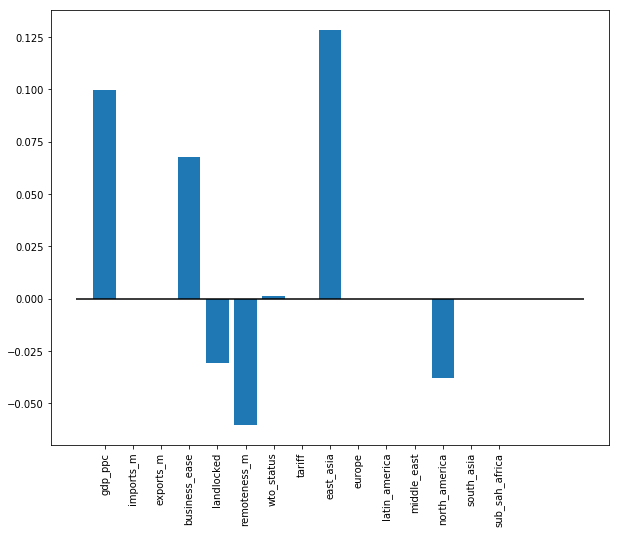

In [141]:
plt.figure(figsize=(10,8))
plt.bar(predictors.columns, model.coef_)
plt.hlines(0,-1,17)
plt.xticks(rotation='vertical')

### The coefficient progression

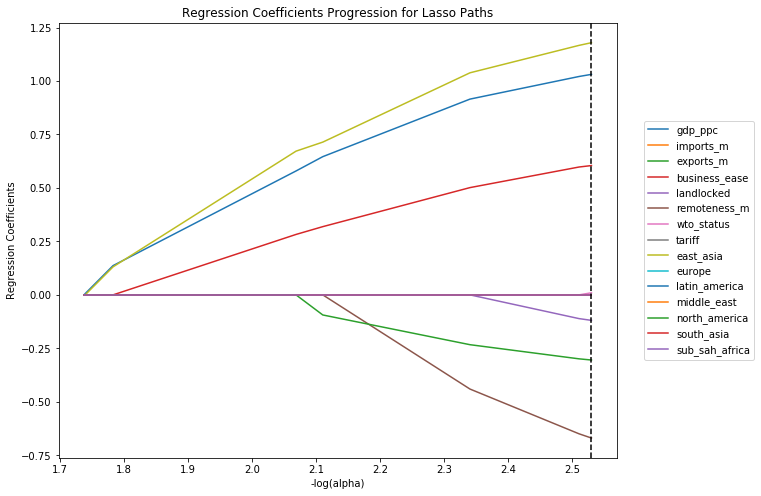

In [142]:
plt.figure(figsize=(10,8))
m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')
plt.legend(predictors.columns, bbox_to_anchor=(1.04,0.5), loc="center left")

### Mean square error for each fold

Text(0.5, 1.0, 'Mean squared error on each fold')

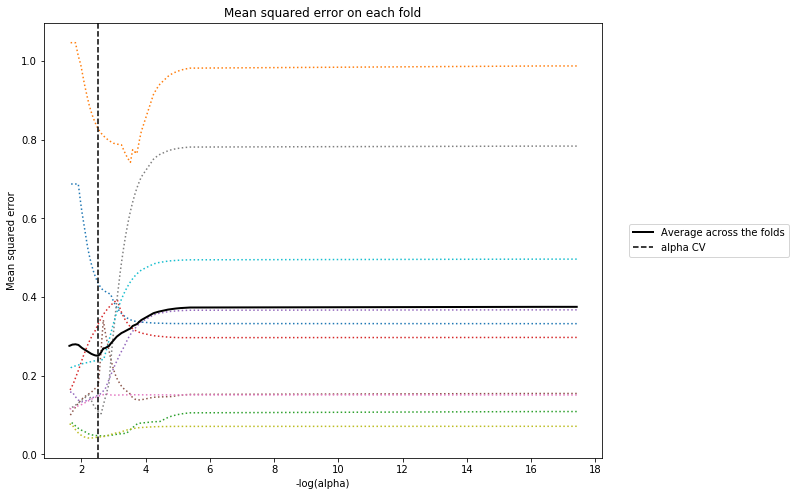

In [147]:
m_log_alphascv = -np.log10(model.cv_alphas_)

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(m_log_alphascv, model.mse_path_, ':')
plt.plot(m_log_alphascv, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

### Statistics

In [144]:
# MSE from training and test data
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)

training data MSE
0.20369851726825897
test data MSE
0.3093956035103206


In [145]:
# R-square from training and test data
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square')
print(rsquared_train)
print ('test data R-square')
print(rsquared_test)

training data R-square
0.24899863752060858
test data R-square
-0.04885505250349498


## Conclusion 

The model removed imports, exports, WTO membership, applied tariff, and all regional dummies, except North America and East Asia & Pacific. From seven variables selected for the final model, the most strongly associated with trade openness were being in East Asia and Income levels of the country, all of those variables were positively associated with Trade Openness. The least associated was whether the country is a member of the WTO or not, which also was positively associated with Trade Openness. Economical remoteness, being a landlocked country, and being located in North America were negatively associated with the Trade Openness.

These 14 variables accounted for 24.9% of the variance in the tarde openness response variable.